# Ornstein–Uhlenbeck (OU) Process for Mean-Reverting Spreads
## 1. Why This is Useful
- Connects **econometrics** (cointegration) with **stochastic calculus** (OU).  
- Closed-form transition density enables **fast MLE**.  
- Parameters $\kappa,\theta,\sigma_y$ give interpretable dials for trading design.
- OU models are mean-reverting — important in finance because many quantities aren’t well modeled by GBM drift-to-infinity:
  - Interest rates: Vasicek model is essentially OU.
  - Volatility dynamics (Heston’s variance process is a square-root diffusion, but OU intuition applies).
  - Pairs trading / spreads: log-price differences between cointegrated assets revert to equilibrium.

## 2. Practical Modeling Pipeline for a Pairs Spread
1. **Pick a pair / basket.**  
2. **Estimate $\beta$ and $\theta$** via cointegration.  
3. **Form the spread** $y_t = \log S_{1,t} - \beta \log S_{2,t} - \theta$ and test stationarity.  
4. **Calibrate OU** using MLE:
   \begin{equation}
   y_{t+\Delta}\,|\,y_t \sim \mathcal{N}\Big(\theta+(y_t-\theta)e^{-\kappa\Delta}, \; \frac{\sigma_y^2}{2\kappa}\big(1-e^{-2\kappa\Delta}\big)\Big).
   \end{equation}
   - Maximize likelihood to obtain $\hat{\kappa}, \hat{\theta}, \hat{\sigma}_y$.  
   - Compute half-life $\ln 2/\hat{\kappa}$.  
5. **Signal & execution.**  
   - Enter trades when standardized spread $z_t=(y_t-\hat{\theta})/\hat{\sigma}_{\text{st}}$ exceeds thresholds.  
   - Exit when $z_t$ reverts to 0.  
   - Size positions by variance forecast and hedge ratio $\beta$.
## 3. OU in Continuous Time (from AR(1) intuition) -- Mathmatical Material
Start with a discrete mean-reverting spread $y_t$:
\begin{equation}
y_{t+\Delta} = (1-\kappa\Delta)\,y_t + \kappa\Delta\,\theta + \sigma\sqrt{\Delta}\,\varepsilon_t, 
\end{equation}
with $\varepsilon_t \sim \mathcal{N}(0,1)$.  

Let $\Delta \to 0$. This converges to the **Ornstein–Uhlenbeck (OU)** SDE:
\begin{equation}
dX_t = \kappa(\theta - X_t)\,dt + \sigma\,dW_t,
\end{equation}
where $\kappa>0$ is the speed of mean reversion, $\theta$ the long-run mean, and $\sigma$ the volatility.

**Solution and properties:**

\begin{equation}
X_t = \theta + (X_0-\theta)e^{-\kappa t} + \sigma\int_0^t e^{-\kappa (t-s)}\,dW_s,
\end{equation}

\begin{equation}
\mathbb{E}[X_t] = \theta + (X_0-\theta)e^{-\kappa t},
\end{equation}

\begin{equation}
\text{ACF}(\tau) = e^{-\kappa \tau}, \quad \text{half-life } \tau_{1/2} = \frac{\ln 2}{\kappa}.
\end{equation}


## 4. How it Appears for the Spread Between Two Stocks
Let two stocks follow correlated GBMs:
\begin{equation}
\frac{dS_1}{S_1} = \mu_1\,dt + \sigma_1\,dW_1, \qquad
\frac{dS_2}{S_2} = \mu_2\,dt + \sigma_2\,dW_2, \qquad dW_1\,dW_2 = \rho\,dt.
\end{equation}

Log prices:
\begin{equation}
d\log S_i = \Big(\mu_i - \tfrac{1}{2}\sigma_i^2\Big)dt + \sigma_i\,dW_i.
\end{equation}

Define a **log-spread**:
\begin{equation}
y_t = \log S_{1,t} - \beta\,\log S_{2,t} - \theta.
\end{equation}

Then:

\begin{equation}
dy_t = \Big(\mu_1 - \beta\mu_2 - \tfrac{1}{2}(\sigma_1^2 - \beta\sigma_2^2)\Big)dt
+ \sigma_1\,dW_1 - \beta\sigma_2\,dW_2.
\end{equation}

To achieve mean reversion, impose an **error-correction condition**:

\begin{equation}
\mu_1 - \beta\mu_2 = -\kappa y_t + \tfrac{1}{2}(\sigma_1^2 - \beta\sigma_2^2).
\end{equation}

Substitute:
\begin{equation}
dy_t = -\kappa y_t \, dt + \sigma_1\,dW_1 - \beta\sigma_2\,dW_2.
\end{equation}

Define effective spread volatility:
\begin{equation}
\sigma_y^2 = \sigma_1^2 + \beta^2\sigma_2^2 - 2\beta\rho\sigma_1\sigma_2,
\end{equation}
and a new Brownian motion $d\widetilde{W}_t$:
\begin{equation}
d\widetilde{W}_t = \frac{\sigma_1\,dW_1 - \beta\sigma_2\,dW_2}{\sigma_y}.
\end{equation}

Finally:
\begin{equation}
dy_t = -\kappa y_t \, dt + \sigma_y \, d\widetilde{W}_t,
\end{equation}
which is exactly an OU process.



## Takeaways

- OU is a **continuous-time AR(1)** with exponential ACF.  
- Exact simulation matches theoretical mean/variance at any step size.  
- OLS on the AR(1) provides **Gaussian MLE** for $(\kappa,\mu,\sigma)$.  
- Diagnostics (ACF + QQ) support **stationarity** and **Gaussian residuals**.  
- **Half-life** $t_{1/2}=\ln 2/\kappa$ offers a direct, interpretable speed of mean reversion.

In [3]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [4]:
%cd $project_root

/Users/zhaoyub/Documents/Tradings/option-mini-lab


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ornstein–Uhlenbeck (OU): Simulation · MLE Calibration · Diagnostics

**Why it matters** (finance):
- Many quantities mean-revert rather than drift to infinity (e.g., short rates à la Vasicek, cointegrated spreads).
- The OU process is Gaussian, stationary, and interpretable: the **half-life** $t_{1/2} = \ln 2/\kappa$ is a direct measure of reversion speed.

**Model**
\begin{equation}
dX_t = \kappa(\mu - X_t)\,dt + \sigma\,dW_t,\quad
X_{t+\Delta}\mid X_t \sim \mathcal{N}\!\Big(\mu+(X_t-\mu)e^{-\kappa\Delta},\ \frac{\sigma^2}{2\kappa}(1-e^{-2\kappa\Delta})\Big).
\end{equation}

**OU ↔ AR(1) mapping**
\begin{equation}
X_{n+1} = a + b X_n + \varepsilon_n,\quad
b = e^{-\kappa\Delta},\ a = \mu(1-b),\ \varepsilon_n\sim \mathcal{N}\!\Big(0,\ \tfrac{\sigma^2}{2\kappa}(1-b^2)\Big).
\end{equation}

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from src.ou import (
    OUParams, simulate_ou_exact, simulate_ou_euler,
    fit_ou_mle, ou_residuals, acf, qq_data, half_life
)

rng = np.random.default_rng(12345678)

## Simulate OU paths (exact vs Euler)

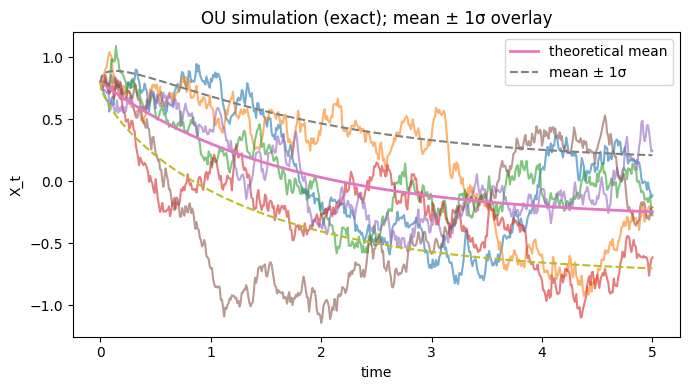

In [16]:
# True parameters
true = OUParams(kappa=0.6, mu=-0.3, sigma=0.5)

# Grid
dt   = 0.01
T    = 5.0
steps = int(T / dt)
t = np.linspace(0, T, steps+1)

# Simulate
x0 = 0.8
n_paths = 50

X_exact = simulate_ou_exact(n_paths, steps, dt, true, x0, rng=rng)
X_euler = simulate_ou_euler(n_paths, steps, dt, true, x0, rng=rng)

# Theoretical mean and std envelope
mean_the = true.mu + (x0 - true.mu) * np.exp(-true.kappa * t)
var_the  = (true.sigma**2) / (2 * true.kappa) * (1 - np.exp(-2 * true.kappa * t))
std_the  = np.sqrt(var_the)

# Plot a few exact paths + theory envelope
plt.figure(figsize=(7,4))
for i in range(min(n_paths, 6)):
    plt.plot(t, X_exact[i], alpha=0.6)
plt.plot(t, mean_the, linewidth=2, label="theoretical mean")
plt.plot(t, mean_the + std_the, linestyle="--", label="mean ± 1σ")
plt.plot(t, mean_the - std_the, linestyle="--")
plt.xlabel("time")
plt.ylabel("X_t")
plt.title("OU simulation (exact); mean ± 1σ overlay")
plt.legend()
plt.tight_layout()
plt.show()

## Euler bias illustration

In [10]:
# Compare final-time distribution mean/var vs theory
def summarize(arr):
    return float(arr.mean()), float(arr.var(ddof=1))

end_exact = X_exact[:, -1]
end_euler = X_euler[:, -1]

m_e, v_e = summarize(end_exact)
m_u, v_u = summarize(end_euler)

print("T = {:.2f}, theory: mean={:.4f}, var={:.4f}".format(T, mean_the[-1], var_the[-1]))
print("Exact : mean={:.4f}, var={:.4f}".format(m_e, v_e))
print("Euler : mean={:.4f}, var={:.4f}".format(m_u, v_u))

T = 5.00, theory: mean=-0.2452, var=0.2078
Exact : mean=-0.4840, var=0.0953
Euler : mean=-0.2504, var=0.1704


## MLE calibration from one long path

Estimated OU params
  kappâ = 0.9348  (true 0.6000)
  mû    = -0.2129     (true -0.3000)
  sigmâ = 0.5002  (true 0.5000)

AR(1) view
  â = -0.001981,  b̂ = 0.990696,  σ_ε̂ = 0.049789
  s.e.(â) = 0.000638, s.e.(b̂) = 0.001517


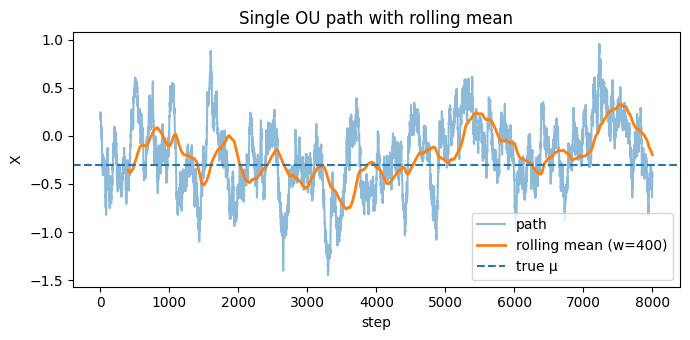

In [11]:
# Use one long exact path for calibration
x = simulate_ou_exact(1, 8000, dt=0.01, params=true, x0=0.2, rng=rng)[0]

fit = fit_ou_mle(x, dt=0.01)
print("Estimated OU params")
print(f"  kappâ = {fit.kappa:.4f}  (true {true.kappa:.4f})")
print(f"  mû    = {fit.mu:.4f}     (true {true.mu:.4f})")
print(f"  sigmâ = {fit.sigma:.4f}  (true {true.sigma:.4f})")
print("\nAR(1) view")
print(f"  â = {fit.a:.6f},  b̂ = {fit.b:.6f},  σ_ε̂ = {fit.sigma_eps:.6f}")
print(f"  s.e.(â) = {fit.stderr_a:.6f}, s.e.(b̂) = {fit.stderr_b:.6f}")

# Visual check: sample vs theory mean/var on this single path (rolling)
w = 400  # rolling window to smooth the single path
roll_mean = np.convolve(x, np.ones(w)/w, mode="valid")
plt.figure(figsize=(7,3.5))
plt.plot(x, alpha=0.5, label="path")
plt.plot(np.arange(w-1, len(x)), roll_mean, linewidth=2, label=f"rolling mean (w={w})")
plt.axhline(true.mu, linestyle="--", label="true μ")
plt.xlabel("step")
plt.ylabel("X")
plt.title("Single OU path with rolling mean")
plt.legend()
plt.tight_layout()
plt.show()

## ACF: empirical vs theoretical

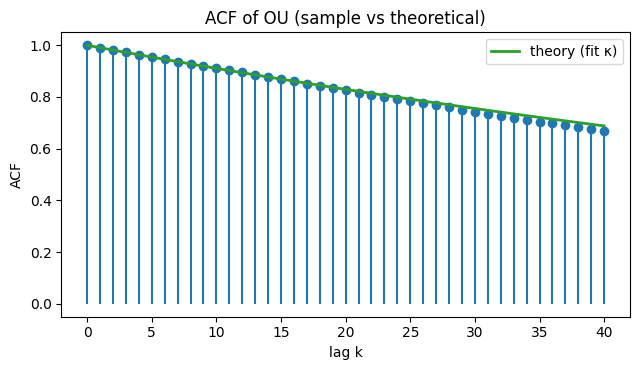

In [13]:
max_lag = 40
r = acf(x, max_lag=max_lag)

# Theoretical discrete ACF: rho(k) = (e^{-kappa dt})^k
rho_the = np.exp(-fit.kappa * np.arange(max_lag+1) * 0.01)

plt.figure(figsize=(6.5,3.8))
plt.stem(range(max_lag+1), r, linefmt='-', markerfmt='o', basefmt=' ')
plt.plot(range(max_lag+1), rho_the, linewidth=2, label="theory (fit κ)")
plt.xlabel("lag k")
plt.ylabel("ACF")
plt.title("ACF of OU (sample vs theoretical)")
plt.legend()
plt.tight_layout()
plt.show()

## QQ-plot of standardized residuals 

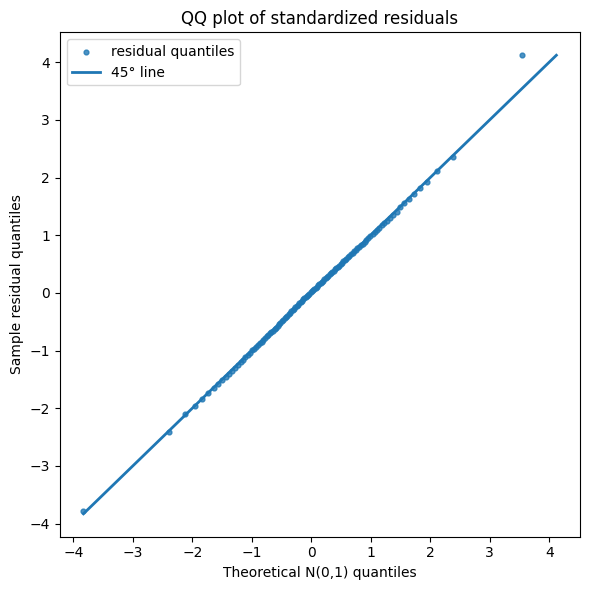

In [14]:
# One-step residuals (AR(1) fitted form)
res = ou_residuals(x, fit)
z = (res - res.mean()) / res.std(ddof=1)

theo_q, samp_q = qq_data(z, n_points=120)

plt.figure(figsize=(6,6))
plt.scatter(theo_q, samp_q, s=12, alpha=0.8, label="residual quantiles")
lims = [min(theo_q.min(), samp_q.min()), max(theo_q.max(), samp_q.max())]
plt.plot(lims, lims, linewidth=2, label="45° line")
plt.xlabel("Theoretical N(0,1) quantiles")
plt.ylabel("Sample residual quantiles")
plt.title("QQ plot of standardized residuals")
plt.legend()
plt.tight_layout()
plt.show()

## Half-life: theory vs empirical

In [15]:
# Theoretical half-life from fitted kappa
t12_the = half_life(fit.kappa)

# Empirical half-life estimate:
# Estimate rho(1) from data, then kappa_emp = -ln(rho(1))/dt, t12_emp = ln(2)/kappa_emp.
rho1 = acf(x, max_lag=1)[1]
rho1 = np.clip(rho1, 1e-6, 1-1e-6)  # numerical guard
kappa_emp = -np.log(rho1) / 0.01
t12_emp = np.log(2.0) / kappa_emp

print(f"Half-life (theory from fit κ): {t12_the:.3f}")
print(f"Half-life (empirical from ρ(1)): {t12_emp:.3f}")

Half-life (theory from fit κ): 0.741
Half-life (empirical from ρ(1)): 0.739


### OU, AR(1) recap

Given sampling step $\Delta t$:
- $b = e^{-\kappa \Delta t}$ controls the ACF slope: $\rho(k) = b^k$.
- $a = \mu(1-b)$ ensures the process reverts to $\mu$.
- Shock variance per step: $\sigma_\varepsilon^2 = \frac{\sigma^2}{2\kappa}(1-b^2)$.

MLE via OLS on $X_{t+1} = a + bX_t + \varepsilon_t$ gives $(\hat a,\hat b)$, then back out
$\hat\kappa, \hat\mu, \hat\sigma$.

## Takeaways

- OU is a **continuous-time AR(1)** with exponential ACF.  
- Exact simulation matches theoretical mean/variance at any step size.  
- OLS on the AR(1) provides **Gaussian MLE** for $(\kappa,\mu,\sigma)$.  
- Diagnostics (ACF + QQ) support **stationarity** and **Gaussian residuals**.  
- **Half-life** $t_{1/2}=\ln 2/\kappa$ offers a direct, interpretable speed of mean reversion.

In [18]:
! jupyter nbconvert --to pdf notebooks/demo_ou.ipynb

[NbConvertApp] Converting notebook notebooks/demo_ou.ipynb to pdf
[NbConvertApp] Support files will be in demo_ou_files/
[NbConvertApp] Making directory ./demo_ou_files
[NbConvertApp] Writing 49220 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 293885 bytes to notebooks/demo_ou.pdf
